# Auswertung QM B

This script provides a data processing for the ZIF Simulation (QM Part B)

In [296]:
import numpy as np

import matplotlib.pyplot as plt

import matplotlib as mpl

import seaborn as sns

import pandas as pd

from scipy.optimize import curve_fit

from scipy.integrate import simpson
from scipy.integrate import cumulative_trapezoid

from scipy.stats import linregress

import scipy.constants as const

Important notes

+ We have a 1ns run with 500 ps for each run

# Analysis of the Empty ZIF

here we plot the lattice parameter against the simulation time

In [297]:
# data readin

lattice_data = pd.read_csv("data_emptyzif8/zif_8_empty-03.box",names=["Steps","a","b","c",1,2,3] , sep="\t")
print(lattice_data)

# The production run was 500 ps, thus we need to transform the time

lattice_data["Steps"] = lattice_data["Steps"] - 10000

max_steps = np.max(lattice_data["Steps"]) 



time_per_step = 500 / max_steps

lattice_data["Steps"] = lattice_data["Steps"] * time_per_step 


average = 17.0862

error = 0.0051


# Define a window size for the running average (e.g., 10 points)
window_size = 1000

# Calculate the running average
lattice_data['Running Average'] = lattice_data['a'].rolling(window=window_size).mean()


# Plot the data
plt.figure(figsize=(8, 6))
plt.plot(lattice_data["Steps"], lattice_data["a"], label='Lattice Parameter', color='b')


# Plot the running average
plt.plot(lattice_data["Steps"], lattice_data["Running Average"], label=f'Running Average (window={window_size})', color='coral', linewidth=2,linestyle = "dotted")


# Plot average as a horizontal line
plt.axhline(average, color='r', linestyle='--', label=f'Average = {average}')

# Plot error as a shaded region
plt.fill_between(lattice_data["Steps"], average - error, average + error, color='green', alpha=0.3, label=f'Error ± {error}')

# Adding labels, title, and legend
plt.xlabel('Time / (ps)')
plt.ylabel('Lattice Parameter  / (Å)')
plt.title('Lattice Parameter vs Time')
plt.legend(
    title="Legend", 
    loc='lower right', 
    frameon=True,   # Enable the box around the legend
    facecolor='white',  # Background color of the box
    edgecolor='black',  # Border color of the box
    fontsize=12,  # Font size for legend text
    title_fontsize=14,  # Font size for the title in the legend
    borderpad=1,  # Padding between the legend content and the box
    borderaxespad=1  # Padding between the legend and the plot
)




# Display the plot
plt.savefig("thermal_expansionzif8.png",dpi=600)
plt.show()


         Steps          a          b          c     1     2     3
0        10001  17.095006  17.095006  17.095006  90.0  90.0  90.0
1        10002  17.095178  17.095178  17.095178  90.0  90.0  90.0
2        10003  17.095294  17.095294  17.095294  90.0  90.0  90.0
3        10004  17.095336  17.095336  17.095336  90.0  90.0  90.0
4        10005  17.095292  17.095292  17.095292  90.0  90.0  90.0
...        ...        ...        ...        ...   ...   ...   ...
249995  259996  17.089498  17.089498  17.089498  90.0  90.0  90.0
249996  259997  17.089607  17.089607  17.089607  90.0  90.0  90.0
249997  259998  17.089702  17.089702  17.089702  90.0  90.0  90.0
249998  259999  17.089769  17.089769  17.089769  90.0  90.0  90.0
249999  260000  17.089813  17.089813  17.089813  90.0  90.0  90.0

[250000 rows x 7 columns]


# Analysis Hydrogen Loading 8

### Einstein Relation

Here we calculate the mean squared displacment (MSD) of the hydrogen molecule. What we need is the MSD file 

In [298]:
data = np.genfromtxt("data_zif8/diff.out")
steps = data[:,0]
# Calculate the step time
time_per_step = 1/np.max(steps)

print(np.max(steps))
# Transform x axis into pS
time = steps * 0.002
MSD_x = data[:,1]
MSD_y = data[:,2]
MSD_z = data[:,3]
MSD_xyz = MSD_x + MSD_y + MSD_z


## further fit some data

def linear_regression(x,a,b):
  return a*x + b

popt, pcov = curve_fit(linear_regression,time[-500:],MSD_xyz[-500:])

d_einstein = popt[0] / 6 

# extract fit parameters and b

a_fit = popt[0]
b_fit = popt[1]

fitted_line = linear_regression(time[-500:],a_fit,b_fit)


df = pd.DataFrame({
    'Time': time,
    'MSD_x': MSD_x,
    'MSD_y': MSD_y,
    'MSD_z': MSD_z,
    'MSD_xyz': MSD_xyz
})

mpl.rcParams["font.size"] = 18
mpl.rcParams["axes.labelsize"] = 25

# Set the plotting style
sns.set(style="white")

# Create the plot
plt.figure(figsize=(10, 6))

plt.axvline(x=time[-500], color='b', linestyle=':', label="Fitting Regime")

# Plot each MSD component
sns.lineplot(data=df, x='Time', y='MSD_x', label='MSD_x', color='b')
sns.lineplot(data=df, x='Time', y='MSD_y', label='MSD_y', color='g')
sns.lineplot(data=df, x='Time', y='MSD_z', label='MSD_z', color='r')
sns.lineplot(data=df, x='Time', y='MSD_xyz', label='MSD_xyz', color='k', linewidth=2)

# Plot the Fit and D
plt.plot(time[-500:], fitted_line , label=f'Linear Fit (a = {a_fit:.2e}; b = {b_fit:2e})', color='r', linestyle='--')

plt.text(8,35, f"$D_s$ = {d_einstein:.3e} ($\AA^2$/ps)")

# Customize the plot
plt.title('Mean Squared Displacement (MSD) vs Time', fontsize=16)
plt.xlabel('Time / (ps)', fontsize=12)
plt.ylabel(r'Mean Squared Displacement (MSD) /  ($\AA^2$)', fontsize=12)
plt.legend(
    title="Legend", 
    loc='upper left', 
    frameon=True,   # Enable the box around the legend
    facecolor='white',  # Background color of the box
    edgecolor='black',  # Border color of the box
    fontsize=12,  # Font size for legend text
    title_fontsize=14,  # Font size for the title in the legend
    borderpad=1,  # Padding between the legend content and the box
    borderaxespad=1  # Padding between the legend and the plot
)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.savefig("MSD_with_einstein_fit_8_loading.png")
plt.show()


5000.0


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

### Green Kubo 

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

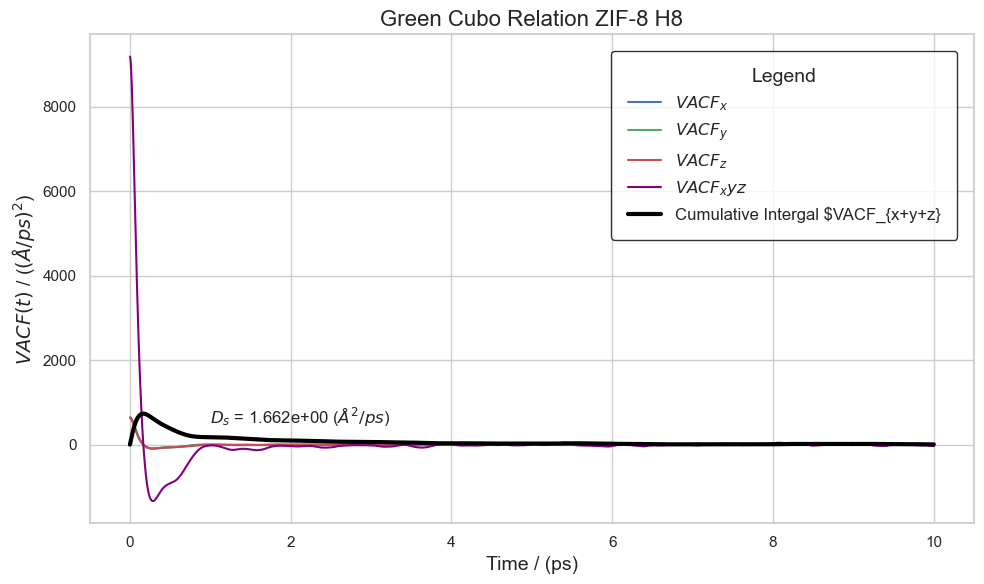

In [299]:


data = np.genfromtxt("data_zif8/green_kubo.out")
time = data[:,0]
VACF_x = data[:,1]
VACF_y = data[:,2]
VACF_z = data[:,3]
VACF_xyz = data[:,4]
VACF_xyz = VACF_xyz*4.78

# When we apply our integral

integral_VACF_xyz = simpson(VACF_xyz, x=time)
cumulative_integral = cumulative_trapezoid(VACF_xyz, time, initial=0)

# Calculate Green Kubo
d_green_kubo = integral_VACF_xyz / 3

# Create the plot using seaborn
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))

# Plot the Individual Components

# Plot the VACF components
sns.lineplot(x=time, y=VACF_x, label="$VACF_x$", color='b', linestyle='-')
sns.lineplot(x=time, y=VACF_y, label="$VACF_y$", color='g', linestyle='-')
sns.lineplot(x=time, y=VACF_z, label="$VACF_z$", color='r', linestyle='-')
sns.lineplot(x=time, y=VACF_xyz, label="$VACF_xyz$", color='purple', linestyle='-')

# Plot cumulative integral
sns.lineplot(x=time, y=cumulative_integral, label="Cumulative Intergal $VACF_{x+y+z}", color='black',linewidth = 3)

plt.text(1,500, f"$D_s$ = {d_green_kubo:.3e} ($\AA^2 /ps$)")

# Plot Simpson's rule result

# Add labels and title
plt.title("Green Cubo Relation ZIF-8 H8", fontsize=16)
plt.xlabel("Time / (ps)", fontsize=14)
plt.ylabel("$VACF(t)$ / ($(\AA / ps)^2$)", fontsize=14)

plt.legend(
    title="Legend", 
    loc='upper right', 
    frameon=True,   # Enable the box around the legend
    facecolor='white',  # Background color of the box
    edgecolor='black',  # Border color of the box
    fontsize=12,  # Font size for legend text
    title_fontsize=14,  # Font size for the title in the legend
    borderpad=1,  # Padding between the legend content and the box
    borderaxespad=1  # Padding between the legend and the plot
)

# Show plot
plt.tight_layout()
plt.savefig("green_kubo_zif8h8.png",dpi=600)
plt.show()

# Analysis ZIF8 hydrogen loading 12

Same analysis just with the other hydrogen loading 

In [300]:
data = np.genfromtxt("data_zif12/diff.out")
steps = data[:,0]
# Calculate the step time
time_per_step = 1/np.max(steps)

print(np.max(steps))
# Transform x axis into pS
time = steps * 0.002
MSD_x = data[:,1]
MSD_y = data[:,2]
MSD_z = data[:,3]
MSD_xyz = MSD_x + MSD_y + MSD_z


## further fit some data

def linear_regression(x,a,b):
  return a*x + b

popt, pcov = curve_fit(linear_regression,time[-500:],MSD_xyz[-500:])

d_einstein = popt[0] / 6 

# extract fit parameters and b

a_fit = popt[0]
b_fit = popt[1]

fitted_line = linear_regression(time[-500:],a_fit,b_fit)


df = pd.DataFrame({
    'Time': time,
    'MSD_x': MSD_x,
    'MSD_y': MSD_y,
    'MSD_z': MSD_z,
    'MSD_xyz': MSD_xyz
})



# Set the plotting style
sns.set(style="white")

# Create the plot
plt.figure(figsize=(10, 6))

plt.axvline(x=time[-500], color='b', linestyle=':', label="Fitting Regime")

# Plot each MSD component
sns.lineplot(data=df, x='Time', y='MSD_x', label='MSD_x', color='b')
sns.lineplot(data=df, x='Time', y='MSD_y', label='MSD_y', color='g')
sns.lineplot(data=df, x='Time', y='MSD_z', label='MSD_z', color='r')
sns.lineplot(data=df, x='Time', y='MSD_xyz', label='MSD_xyz', color='k', linewidth=2)

# Plot the Fit and D
plt.plot(time[-500:], fitted_line , label=f'Linear Fit (a = {a_fit:.2e}; b = {b_fit:2e})', color='r', linestyle='--')

plt.text(8,28, f"$D_s$ = {d_einstein:.3e} ($\AA^2$/ps)")

# Customize the plot
plt.title('Mean Squared Displacement (MSD) vs Time', fontsize=16)
plt.xlabel('Time / (ps)', fontsize=12)
plt.ylabel(r'Mean Squared Displacement (MSD) /  ($\AA^2$)', fontsize=12)
plt.legend(
    title="Legend", 
    loc='upper left', 
    frameon=True,   # Enable the box around the legend
    facecolor='white',  # Background color of the box
    edgecolor='black',  # Border color of the box
    fontsize=12,  # Font size for legend text
    title_fontsize=14,  # Font size for the title in the legend
    borderpad=1,  # Padding between the legend content and the box
    borderaxespad=1  # Padding between the legend and the plot
)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.savefig("MSD_with_einstein_fit_12_loading.png")
plt.show()

5000.0


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

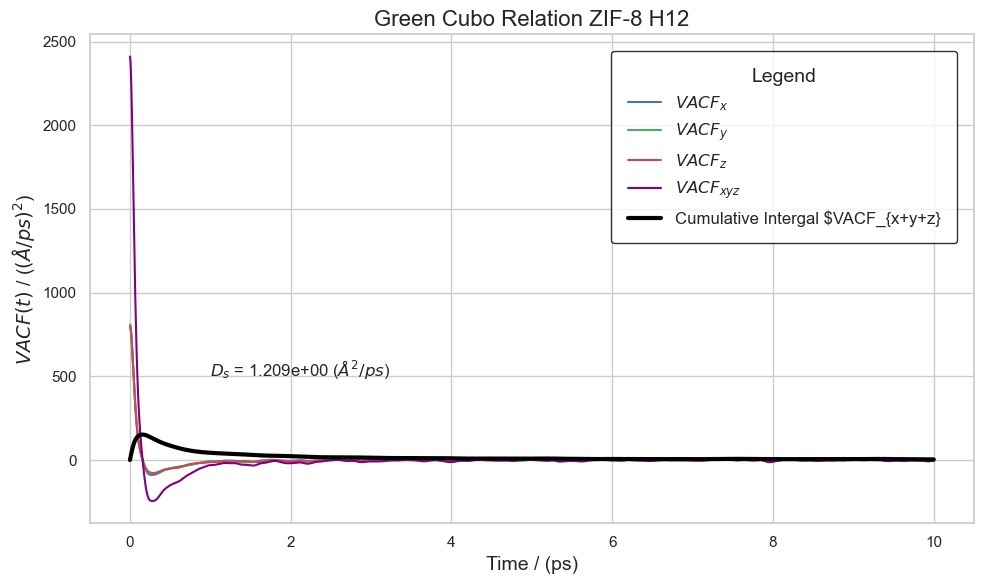

In [301]:
data = np.genfromtxt("data_zif12/green_kubo.out")
time = data[:,0]
VACF_x = data[:,1]
VACF_y = data[:,2]
VACF_z = data[:,3]
VACF_xyz = data[:,4]

# When we apply our integral

integral_VACF_xyz = simpson(VACF_xyz, x=time)
cumulative_integral = cumulative_trapezoid(VACF_xyz, time, initial=0)

# Calculate Green Kubo
d_green_kubo = integral_VACF_xyz / 3

# Create the plot using seaborn
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))

# Plot the Individual Components

# Plot the VACF components
sns.lineplot(x=time, y=VACF_x, label="$VACF_x$", color='b', linestyle='-')
sns.lineplot(x=time, y=VACF_y, label="$VACF_y$", color='g', linestyle='-')
sns.lineplot(x=time, y=VACF_z, label="$VACF_z$", color='r', linestyle='-')
sns.lineplot(x=time, y=VACF_xyz, label="$VACF_{xyz}$", color='purple', linestyle='-')

# Plot cumulative integral
sns.lineplot(x=time, y=cumulative_integral, label="Cumulative Intergal $VACF_{x+y+z}", color='black',linewidth = 3)

plt.text(1,500, f"$D_s$ = {d_green_kubo:.3e} ($\AA^2 /ps$)")

# Plot Simpson's rule result

# Add labels and title
plt.title("Green Cubo Relation ZIF-8 H12", fontsize=16)
plt.xlabel("Time / (ps)", fontsize=14)
plt.ylabel("$VACF(t)$ / ($(\AA / ps)^2$)", fontsize=14)

plt.legend(
    title="Legend", 
    loc='upper right', 
    frameon=True,   # Enable the box around the legend
    facecolor='white',  # Background color of the box
    edgecolor='black',  # Border color of the box
    fontsize=12,  # Font size for legend text
    title_fontsize=14,  # Font size for the title in the legend
    borderpad=1,  # Padding between the legend content and the box
    borderaxespad=1  # Padding between the legend and the plot
)

# Show plot
plt.tight_layout()
plt.savefig("green_kubo_zif8h12.png",dpi=600)
plt.show()

### Activation Energy

The Diffusion Coefficient is directly depending on the activation energy $E_a$ by an exponential decay

$D_s = D_0 e^{\frac{E_a}{RT}}$

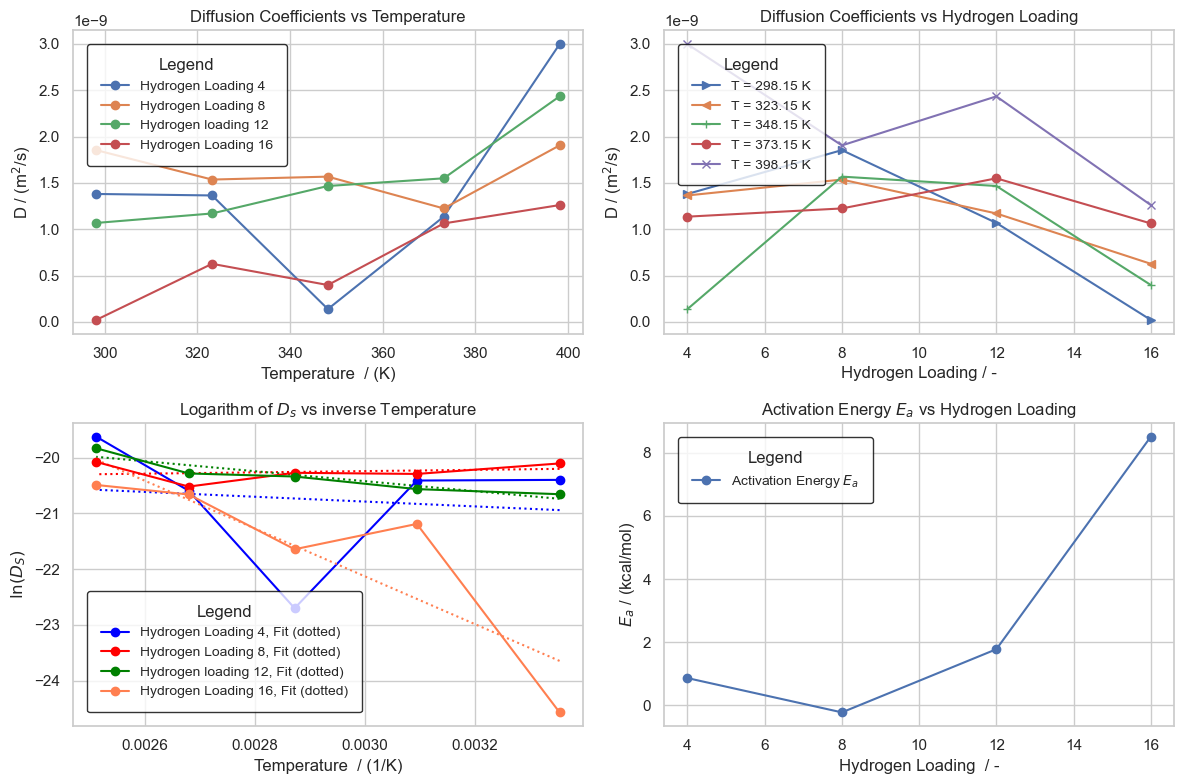

In [330]:
data = {
    "Temperature (K)": [298.15, 323.15, 348.15, 373.15, 398.15],
    "D4": [1.3805E-9, 0.0000000013645, 0.00000000013824, 0.0000000011356, 0.0000000029965],
    "D8": [0.0000000018536, 0.0000000015359, 0.0000000015675, 0.0000000012243, 0.0000000019045],
    "D12": [0.0000000010678, 0.00000000117, 0.0000000014665, 0.0000000015493, 0.0000000024336],
    "D16": [2.1358E-11, 0.0000000006268, 0.00000000039789, 0.0000000010624,  0.0000000012605 ]
}

# Create DataFrame
df = pd.DataFrame(data)

data_loading = {
    "n": [4,8,12,16],
    "T_298": [1.3805E-9, 0.0000000018536,0.0000000010678, 2.1358E-11],
    "T_323": [0.0000000013645,0.0000000015359, 0.00000000117, 0.0000000006268],
    "T_348": [ 0.00000000013824, 0.0000000015675, 0.0000000014665, 0.00000000039789],
    "T_373": [0.0000000011356,0.0000000012243, 0.0000000015493, 0.0000000010624],
    "T_398": [0.0000000029965, 0.0000000019045, 0.0000000024336, 0.0000000012605 ]
}

df2 = pd.DataFrame(data_loading)
# Basically we do 4 subplots here

fig, axs = plt.subplots(2, 2, figsize=(12, 8))


# First Subplot

axs[0,0].plot(df["Temperature (K)"], df["D4"], label="Hydrogen Loading 4", marker='o')
axs[0,0].plot(df["Temperature (K)"], df["D8"], label="Hydrogen Loading 8", marker='o')
axs[0,0].plot(df["Temperature (K)"], df["D12"], label="Hydrogen loading 12", marker='o')
axs[0,0].plot(df["Temperature (K)"], df["D16"], label="Hydrogen Loading 16", marker='o')
axs[0,0].set_xlabel('Temperature  / (K)')
axs[0,0].set_ylabel('D / (m$^2$/s)')
axs[0,0].set_title('Diffusion Coefficients vs Temperature')

axs[0,0].legend(
    title="Legend", 
    loc='upper left', 
    frameon=True,   # Enable the box around the legend
    facecolor='white',  # Background color of the box
    edgecolor='black',  # Border color of the box
    fontsize=10,  # Font size for legend text
    title_fontsize=12,  # Font size for the title in the legend
    borderpad=1,  # Padding between the legend content and the box
    borderaxespad=1  # Padding between the legend and the plot
)

# For the Second Subplot we Do the Diffusion Coefficient against the hydrogen loading 

axs[0,1].plot(df2["n"],df2["T_298"], label="T = 298.15 K", marker =">")
axs[0,1].plot(df2["n"],df2["T_323"], label="T = 323.15 K", marker ="<")
axs[0,1].plot(df2["n"], df2["T_348"], label="T = 348.15 K", marker = "+")
axs[0,1].plot(df2["n"], df2["T_373"], label="T = 373.15 K", marker = "o")
axs[0,1].plot(df2["n"], df2["T_398"], label="T = 398.15 K", marker = "x")
axs[0,1].set_xlabel('Hydrogen Loading / -')
axs[0,1].set_ylabel('D / (m$^2$/s)')
axs[0,1].set_title('Diffusion Coefficients vs Hydrogen Loading')
axs[0,1].legend(
    title="Legend", 
    loc='upper left', 
    frameon=True,   # Enable the box around the legend
    facecolor='white',  # Background color of the box
    edgecolor='black',  # Border color of the box
    fontsize=10,  # Font size for legend text
    title_fontsize=12,  # Font size for the title in the legend
    borderpad=1,  # Padding between the legend content and the box
    borderaxespad=1  # Padding between the legend and the plot
)


# For the fourth subplot we do  1/T with ln of Ds

df["D4"] = np.log(df["D4"])
df["D8"] = np.log(df["D8"])
df["D12"] = np.log(df["D12"])
df["D16"] = np.log(df["D16"])
df["Temperature (K)"] = 1/df["Temperature (K)"]


# Linear FIT THIS SHIIITTTT

slope1, intercept1, r_value1, p_value1, std_err = linregress(df["Temperature (K)"],df["D4"])


fit_1 = slope1*df["Temperature (K)"] + intercept1


slope2, intercept2, r_value2, p_value2, std_err = linregress(df["Temperature (K)"],df["D8"])


fit_2 = slope2*df["Temperature (K)"] + intercept2

slope3, intercept3, r_value3, p_value3, std_err = linregress(df["Temperature (K)"],df["D12"])


fit_3 = slope3*df["Temperature (K)"] + intercept3

slope4, intercept4, r_value4, p_value4, std_err = linregress(df["Temperature (K)"],df["D16"])


fit_4 = slope4*df["Temperature (K)"] + intercept4


######### For the last plot calculate the activation energy using the FIT


# when M is slope we have -Ea/R thus E_a = -m*R

# in kcal
e_1 = - slope1*const.R  /4184
e_2 = -slope2*const.R / 4184
e_3 = -slope3*const.R / 4184
e_4 = -slope4*const.R / 4184 

last_plot_fuck = {
    "n" : [4,8,12,16],
    "Ea": [e_1,e_2,e_3,e_4]
}

last_plot_fuck = pd.DataFrame(last_plot_fuck)


axs[1,0].plot(df["Temperature (K)"], df["D4"], label="Hydrogen Loading 4, Fit (dotted)", marker='o',color="blue")



axs[1,0].plot(df["Temperature (K)"],fit_1,linestyle="dotted", color="blue")

axs[1,0].plot(df["Temperature (K)"],fit_2,linestyle="dotted", color="red" )

axs[1,0].plot(df["Temperature (K)"],fit_3,linestyle="dotted", color="green" )

axs[1,0].plot(df["Temperature (K)"],fit_4,linestyle="dotted", color="coral" )


axs[1,0].plot(df["Temperature (K)"], df["D8"], label="Hydrogen Loading 8, Fit (dotted)", marker='o',color="red")
axs[1,0].plot(df["Temperature (K)"], df["D12"], label="Hydrogen loading 12, Fit (dotted)", marker='o',color="green")
axs[1,0].plot(df["Temperature (K)"], df["D16"], label="Hydrogen Loading 16, Fit (dotted)", marker='o',color="coral")
axs[1,0].set_xlabel('Temperature  / (1/K)')
axs[1,0].set_ylabel('$\ln(D_S)$')
axs[1,0].set_title('Logarithm of $D_s$ vs inverse Temperature')

axs[1,0].legend(
    title="Legend", 
    loc='lower left', 
    frameon=True,   # Enable the box around the legend
    facecolor='white',  # Background color of the box
    edgecolor='black',  # Border color of the box
    fontsize=10,  # Font size for legend text
    title_fontsize=12,  # Font size for the title in the legend
    borderpad=1,  # Padding between the legend content and the box
    borderaxespad=1  # Padding between the legend and the plot
)

axs[1,1].plot(last_plot_fuck["n"],last_plot_fuck["Ea"],label="Activation Energy $E_a$",marker = "o")
axs[1,1].set_xlabel('Hydrogen Loading  / -')
axs[1,1].set_ylabel('$E_a$ / (kcal/mol)')
axs[1,1].set_title('Activation Energy $E_a$ vs Hydrogen Loading')

axs[1,1].legend(
    title="Legend", 
    loc='upper left', 
    frameon=True,   # Enable the box around the legend
    facecolor='white',  # Background color of the box
    edgecolor='black',  # Border color of the box
    fontsize=10,  # Font size for legend text
    title_fontsize=12,  # Font size for the title in the legend
    borderpad=1,  # Padding between the legend content and the box
    borderaxespad=1  # Padding between the legend and the plot
)

plt.tight_layout()
plt.savefig("einstein_diffusion_activation_energy.png",dpi=600)
plt.show()

# And do the same thing for the Green-KUBO shit

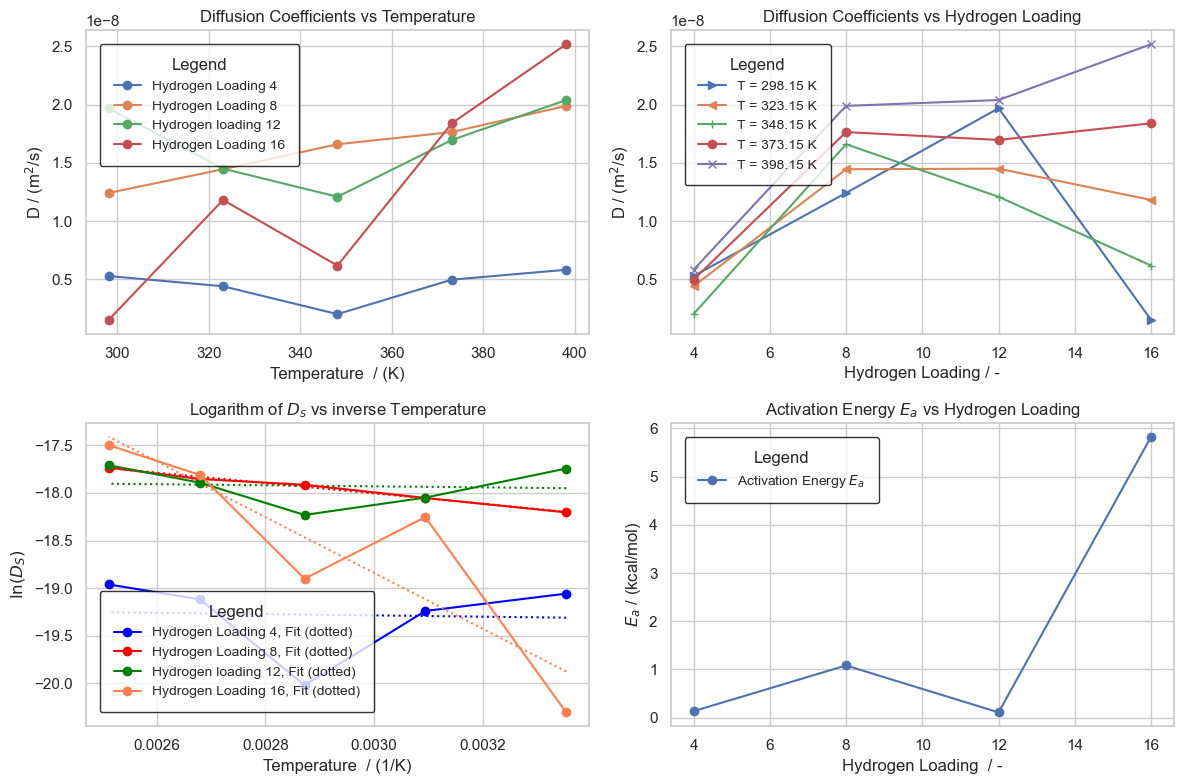

In [333]:
data = {
    "Temperature (K)": [298.15, 323.15, 348.15, 373.15, 398.15],
    "D4": [5.2866E-9, 0.0000000044049, 0.0000000020146, 0.0000000049729, 0.0000000058239],
    "D8": [0.000000012419, 0.000000014456, 0.0000000166, 0.000000017646, 0.000000019896],
    "D12": [0.000000019691, 0.000000014506, 0.00000001209, 0.000000016968, 0.000000020397],
    "D16": [0.0000000015165, 0.000000011817, 0.0000000061839, 0.000000018402,  0.000000025191]
}

# Create DataFrame
df = pd.DataFrame(data)

data_loading = {
    "n": [4,8,12,16],
    "T_298": [5.2866E-9, 0.000000012419,0.000000019691, 0.0000000015165],
    "T_323": [0.0000000044049,0.000000014456, 0.000000014506, 0.000000011817],
    "T_348": [ 0.0000000020146, 0.0000000166, 0.00000001209, 0.0000000061839],
    "T_373": [0.0000000049729,0.000000017646, 0.000000016968, 0.000000018402],
    "T_398": [0.0000000058239, 0.000000019896, 0.000000020397, 0.000000025191 ]
}

df2 = pd.DataFrame(data_loading)
# Basically we do 4 subplots here

fig, axs = plt.subplots(2, 2, figsize=(12, 8))


# First Subplot

axs[0,0].plot(df["Temperature (K)"], df["D4"], label="Hydrogen Loading 4", marker='o')
axs[0,0].plot(df["Temperature (K)"], df["D8"], label="Hydrogen Loading 8", marker='o')
axs[0,0].plot(df["Temperature (K)"], df["D12"], label="Hydrogen loading 12", marker='o')
axs[0,0].plot(df["Temperature (K)"], df["D16"], label="Hydrogen Loading 16", marker='o')
axs[0,0].set_xlabel('Temperature  / (K)')
axs[0,0].set_ylabel('D / (m$^2$/s)')
axs[0,0].set_title('Diffusion Coefficients vs Temperature')

axs[0,0].legend(
    title="Legend", 
    loc='upper left', 
    frameon=True,   # Enable the box around the legend
    facecolor='white',  # Background color of the box
    edgecolor='black',  # Border color of the box
    fontsize=10,  # Font size for legend text
    title_fontsize=12,  # Font size for the title in the legend
    borderpad=1,  # Padding between the legend content and the box
    borderaxespad=1  # Padding between the legend and the plot
)

# For the Second Subplot we Do the Diffusion Coefficient against the hydrogen loading 

axs[0,1].plot(df2["n"],df2["T_298"], label="T = 298.15 K", marker =">")
axs[0,1].plot(df2["n"],df2["T_323"], label="T = 323.15 K", marker ="<")
axs[0,1].plot(df2["n"], df2["T_348"], label="T = 348.15 K", marker = "+")
axs[0,1].plot(df2["n"], df2["T_373"], label="T = 373.15 K", marker = "o")
axs[0,1].plot(df2["n"], df2["T_398"], label="T = 398.15 K", marker = "x")
axs[0,1].set_xlabel('Hydrogen Loading / -')
axs[0,1].set_ylabel('D / (m$^2$/s)')
axs[0,1].set_title('Diffusion Coefficients vs Hydrogen Loading')
axs[0,1].legend(
    title="Legend", 
    loc='upper left', 
    frameon=True,   # Enable the box around the legend
    facecolor='white',  # Background color of the box
    edgecolor='black',  # Border color of the box
    fontsize=10,  # Font size for legend text
    title_fontsize=12,  # Font size for the title in the legend
    borderpad=1,  # Padding between the legend content and the box
    borderaxespad=1  # Padding between the legend and the plot
)


# For the fourth subplot we do  1/T with ln of Ds

df["D4"] = np.log(df["D4"])
df["D8"] = np.log(df["D8"])
df["D12"] = np.log(df["D12"])
df["D16"] = np.log(df["D16"])
df["Temperature (K)"] = 1/df["Temperature (K)"]


# Linear FIT THIS SHIIITTTT

slope1, intercept1, r_value1, p_value1, std_err = linregress(df["Temperature (K)"],df["D4"])


fit_1 = slope1*df["Temperature (K)"] + intercept1


slope2, intercept2, r_value2, p_value2, std_err = linregress(df["Temperature (K)"],df["D8"])


fit_2 = slope2*df["Temperature (K)"] + intercept2

slope3, intercept3, r_value3, p_value3, std_err = linregress(df["Temperature (K)"],df["D12"])


fit_3 = slope3*df["Temperature (K)"] + intercept3

slope4, intercept4, r_value4, p_value4, std_err = linregress(df["Temperature (K)"],df["D16"])


fit_4 = slope4*df["Temperature (K)"] + intercept4


######### For the last plot calculate the activation energy using the FIT


# when M is slope we have -Ea/R thus E_a = -m*R

# in kcal
e_1 = - slope1*const.R  /4184
e_2 = -slope2*const.R / 4184
e_3 = -slope3*const.R / 4184
e_4 = -slope4*const.R / 4184 

last_plot_fuck = {
    "n" : [4,8,12,16],
    "Ea": [e_1,e_2,e_3,e_4]
}

last_plot_fuck = pd.DataFrame(last_plot_fuck)


axs[1,0].plot(df["Temperature (K)"], df["D4"], label="Hydrogen Loading 4, Fit (dotted)", marker='o',color="blue")



axs[1,0].plot(df["Temperature (K)"],fit_1,linestyle="dotted", color="blue")

axs[1,0].plot(df["Temperature (K)"],fit_2,linestyle="dotted", color="red" )

axs[1,0].plot(df["Temperature (K)"],fit_3,linestyle="dotted", color="green" )

axs[1,0].plot(df["Temperature (K)"],fit_4,linestyle="dotted", color="coral" )


axs[1,0].plot(df["Temperature (K)"], df["D8"], label="Hydrogen Loading 8, Fit (dotted)", marker='o',color="red")
axs[1,0].plot(df["Temperature (K)"], df["D12"], label="Hydrogen loading 12, Fit (dotted)", marker='o',color="green")
axs[1,0].plot(df["Temperature (K)"], df["D16"], label="Hydrogen Loading 16, Fit (dotted)", marker='o',color="coral")
axs[1,0].set_xlabel('Temperature  / (1/K)')
axs[1,0].set_ylabel('$\ln(D_S)$')
axs[1,0].set_title('Logarithm of $D_s$ vs inverse Temperature')

axs[1,0].legend(
    title="Legend", 
    loc='lower left', 
    frameon=True,   # Enable the box around the legend
    facecolor='white',  # Background color of the box
    edgecolor='black',  # Border color of the box
    fontsize=10,  # Font size for legend text
    title_fontsize=12,  # Font size for the title in the legend
    borderpad=1,  # Padding between the legend content and the box
    borderaxespad=1  # Padding between the legend and the plot
)

axs[1,1].plot(last_plot_fuck["n"],last_plot_fuck["Ea"],label="Activation Energy $E_a$",marker = "o")
axs[1,1].set_xlabel('Hydrogen Loading  / -')
axs[1,1].set_ylabel('$E_a$ / (kcal/mol)')
axs[1,1].set_title('Activation Energy $E_a$ vs Hydrogen Loading')

axs[1,1].legend(
    title="Legend", 
    loc='upper left', 
    frameon=True,   # Enable the box around the legend
    facecolor='white',  # Background color of the box
    edgecolor='black',  # Border color of the box
    fontsize=10,  # Font size for legend text
    title_fontsize=12,  # Font size for the title in the legend
    borderpad=1,  # Padding between the legend content and the box
    borderaxespad=1  # Padding between the legend and the plot
)

plt.tight_layout()

plt.savefig("green_kubo_diffusion_activation_energy.png",dpi=600)
plt.show()

# Thermal Expansion

For this thermal expansion we can take the data 

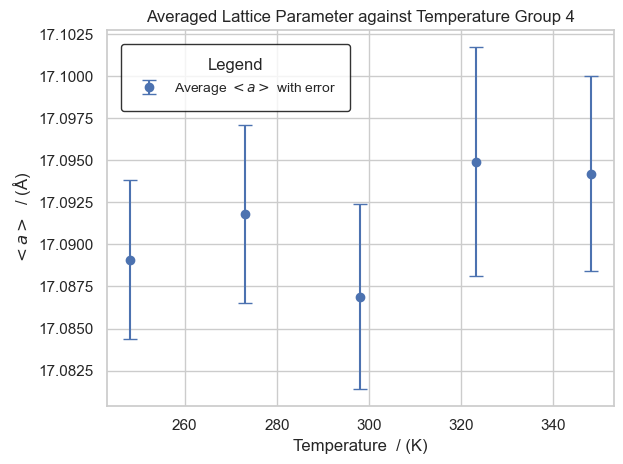

In [334]:
data = {
    "T / K": [248.15, 273.15, 298.15, 323.15, 348.15],
    "<a> / Å": [17.0891, 17.0918, 17.0869, 17.0949, 17.0942],
    "error / Å": [0.0047, 0.0053, 0.0055, 0.0068, 0.0058]
}




df = pd.DataFrame(data)



# Plotting <a> against T with error bars
plt.errorbar(df["T / K"], df["<a> / Å"], yerr=df["error / Å"], fmt='o', capsize=5, label="Average $<a>$ with error")

# Adding labels and title
plt.xlabel("Temperature  / (K)")
plt.ylabel("$<a>$  / (Å)")
plt.title("Averaged Lattice Parameter against Temperature Group 4")
plt.grid(True)
plt.legend(
    title="Legend", 
    loc='upper left', 
    frameon=True,   # Enable the box around the legend
    facecolor='white',  # Background color of the box
    edgecolor='black',  # Border color of the box
    fontsize=10,  # Font size for legend text
    title_fontsize=12,  # Font size for the title in the legend
    borderpad=1,  # Padding between the legend content and the box
    borderaxespad=1  # Padding between the legend and the plot
)

# Show the plot
plt.tight_layout()
plt.savefig("lattice_parameter_group_4.png",dpi=600)
plt.show()

